In [433]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dense, Dropout,
    BatchNormalization, Flatten
)

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_csv_file_paths(root_dir):
    file_paths = []
    labels = []



    
    for user_folder in sorted(os.listdir(root_dir)):
        user_path = os.path.join(root_dir, user_folder)
        if os.path.isdir(user_path):
            for movement_folder in sorted(os.listdir(user_path)):
                movement_path = os.path.join(user_path, movement_folder)
                if os.path.isdir(movement_path):
                    for file in sorted(os.listdir(movement_path)):
                        if file.endswith(".csv"):
                            file_paths.append(os.path.join(movement_path, file))
                            labels.append(movement_folder)
    
    return file_paths, labels

In [435]:
dataset_path = "data/"
file_paths, labels = get_csv_file_paths(dataset_path)

In [ ]:
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df

,file_path,label
0,data/01\down\01_down_1_1.csv,down
1,data/01\down\01_down_1_2.csv,down
2,data/01\down\01_down_1_3.csv,down
3,data/01\down\01_down_1_4.csv,down
4,data/01\down\01_down_1_5.csv,down
5,data/01\down\01_down_1_6.csv,down
6,data/01\down\01_down_1_7.csv,down
7,data/01\down\01_down_1_8.csv,down
8,data/01\grasp\01_grasp_1_1.csv,grasp
9,data/01\grasp\01_grasp_1_2.csv,grasp


In [437]:
movement_mapping = {
    "left": 0,
    "right": 1,
    "up": 2, 
    "down": 3,
    "release": 4, 
    "grasp": 5
}

In [438]:
reverse_mapping = {v: k for k, v in movement_mapping.items()}

In [439]:
reverse_mapping

{0: 'left', 1: 'right', 2: 'up', 3: 'down', 4: 'release', 5: 'grasp'}

In [440]:
def find_min_seq_length(file_paths):
    lengths = []
    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df = df[df['EEG.Interpolated'] != 1]  
        
        if df.shape[0] > 0:  
            lengths.append(len(df))

    min_length = min(lengths)  
    
    print(f"Minimum length across all files: {min_length}")
    
    return min_length

In [441]:
min_length = find_min_seq_length(file_paths)


Minimum length across all files: 364


In [442]:
def load_single_csv(file_path, seq_length=None):
    df = pd.read_csv(file_path)
    
    columns_to_drop = ['OriginalTimestamp', 'EEG.BatteryPercent']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    
   
    df = df[df['EEG.Interpolated'] != 1]
    
    scaler = StandardScaler()
    df_values = scaler.fit_transform(df.values)
    
    features = df_values
    
   
    if len(features) > seq_length:
    
        features = features[:seq_length]
    
    
    num_features = features.shape[1]
    features = features.reshape(1, len(features), num_features)
    
    return features

In [443]:
def load_all_data(file_paths, labels, seq_length):
    X = []
    y = []
    for i, (file_path, label) in enumerate(zip(file_paths, labels)):
        features = load_single_csv(file_path, seq_length)


        
        X.append(features[0])
        y.append(movement_mapping[label])


    return np.array(X), np.array(y)


In [444]:


def create_model(input_shape, num_classes):

    model = Sequential()

    model.add(Conv1D(32, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.15))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [445]:
feature_count = X.shape[2]
print(f"Feature count: {feature_count}")


Feature count: 19


In [446]:
X, y = load_all_data(file_paths, labels, min_length)

In [447]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [448]:
# Calculate class weights to handle imbalance 

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: np.float64(0.8958333333333334),
 1: np.float64(1.0238095238095237),
 2: np.float64(1.0238095238095237),
 3: np.float64(1.0238095238095237),
 4: np.float64(1.0238095238095237),
 5: np.float64(1.0238095238095237)}

In [449]:
input_shape = (min_length, feature_count)
num_classes = len(movement_mapping)
model = create_model(input_shape, num_classes)


c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [450]:
model.summary()



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_50 (Conv1D)              │ (None, 364, 32)        │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 364, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 182, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 182, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 182, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 182, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 91, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 91, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 45, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 22, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 22, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 5632)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       721,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 864,902 (3.30 MB)

 Trainable params: 863,558 (3.29 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [451]:
# Callbacks 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)



In [452]:
print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

Training model...
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1801 - loss: 3.0068 - val_accuracy: 0.1111 - val_loss: 2.4627 - learning_rate: 0.0010
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4700 - loss: 1.9525 - val_accuracy: 0.1111 - val_loss: 2.4900 - learning_rate: 0.0010
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4504 - loss: 1.9516 - val_accuracy: 0.0000e+00 - val_loss: 2.5110 - learning_rate: 0.0010
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6605 - loss: 1.5693 - val_accuracy: 0.1111 - val_loss: 2.5272 - learning_rate: 0.0010
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7506 - loss: 1.3971 - val_accuracy: 0.2222 - val_loss: 2.5324 - learning_rate: 0.0010
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8107 - loss: 1.2951 - val_accuracy: 0.2222 - val_loss: 2.5263 - learning_rate: 0.0010
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7506 - loss: 1

In [453]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.1818 - loss: 2.4218
Test accuracy: 0.1818


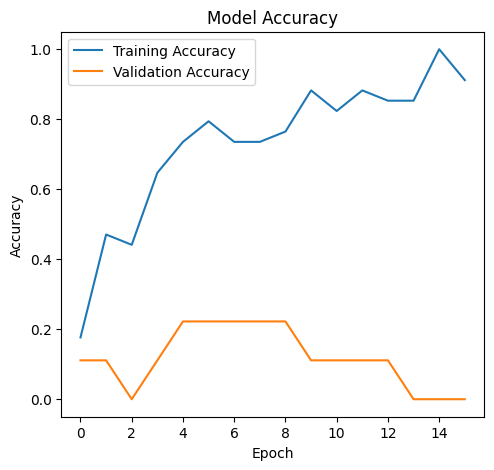

In [454]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

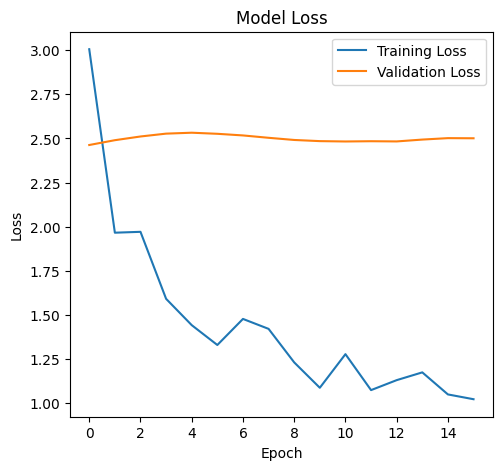

In [455]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


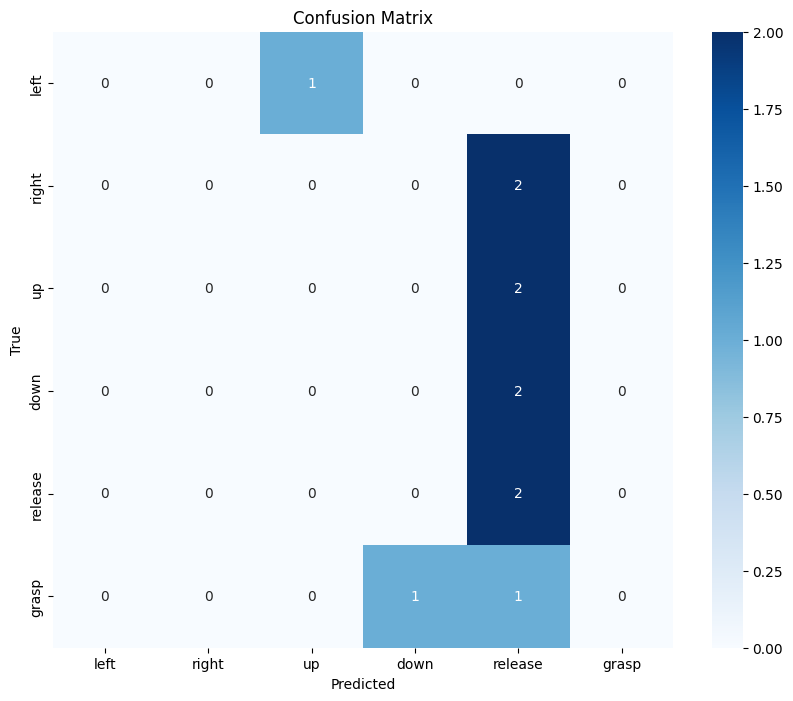

In [456]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_mapping[i] for i in range(num_classes)],
            yticklabels=[reverse_mapping[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


In [457]:
print("\nClassification Report:")
cr = classification_report(
    y_test, 
    y_pred_classes,
    target_names=[reverse_mapping[i] for i in range(num_classes)]
)
print(cr)


Classification Report:
              precision    recall  f1-score   support

        left       0.00      0.00      0.00         1
       right       0.00      0.00      0.00         2
          up       0.00      0.00      0.00         2
        down       0.00      0.00      0.00         2
     release       0.22      1.00      0.36         2
       grasp       0.00      0.00      0.00         2

    accuracy                           0.18        11
   macro avg       0.04      0.17      0.06        11
weighted avg       0.04      0.18      0.07        11



c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera